#### In this notebook, we will explore the usage of MultiNodeWeightedSampler in torchdata.nodes


##### MultiNodeWeightedSampler allows us to sample with a probability from multiple datsets
##### We will load three datasets from CSVs, and see how changing the sampling probability affects the final model predictions

In [1]:
import torch
from torch.utils.data import default_collate 
from torch.utils.data import Dataset, DataLoader, random_split, SequentialSampler


In [2]:
from utils import csv_reader, MDS_Net

In [3]:
# We will load the datasets from the local folder
# gaussian dataset has a list of x and y with x between -1 and 1 and y follwing a Gaussian distribution.
# Similar for uniform and lognormal distribution datasets
gaussian_data = csv_reader('mds_data/gaussian_dataset.csv',)
uniform_data = csv_reader('mds_data/uniform_dataset.csv',)
lognormal_data = csv_reader('mds_data/lognormal_dataset.csv',)

In [4]:
#Let's carry out the test train split and utilize a random sampler
# We are not going to utilize the test datasets for this example, however, we are constructing them for completeness

train_fraction = 0.8
num_train_samples = int(train_fraction*len(gaussian_data))
num_test_samples = len(gaussian_data)- num_train_samples

def get_random_sampler_split(dataset, num_train_samples, num_test_samples):
    train_dataset, test_dataset = random_split(dataset, [num_train_samples, num_test_samples])
    return train_dataset, SequentialSampler(train_dataset), test_dataset, SequentialSampler(test_dataset) 
    # We can use a SequentialSampler because the data are already randomized by the random_split()
    
train_dataset_gaussian, train_sampler_gaussian, _ , _ = get_random_sampler_split(gaussian_data, num_train_samples, num_test_samples)

train_dataset_uniform, train_sampler_uniform, _ , _ = get_random_sampler_split(uniform_data, num_train_samples, num_test_samples)

train_dataset_lognormal, train_sampler_lognormal, _ , _ = get_random_sampler_split(lognormal_data, num_train_samples, num_test_samples)



In [5]:
# All torchdata.nodes.BaseNode implementations are Iterators.
# MapStyleWrapper creates an Iterator that combines sampler and train_dataset to create an iterator.
from torchdata.nodes import MapStyleWrapper, ParallelMapper, Batcher, PinMemory, Loader
gaussian_node = MapStyleWrapper(map_dataset = train_dataset_gaussian, sampler = train_sampler_gaussian)

uniform_node = MapStyleWrapper(map_dataset = train_dataset_uniform, sampler = train_sampler_uniform)

lognormal_node = MapStyleWrapper(map_dataset = train_dataset_lognormal, sampler = train_sampler_lognormal)

#We need a mapper function to convert a dtype 
def map_fn(item):
    return {"x":torch.tensor(item[0], dtype= torch.float32).unsqueeze(0), "y":torch.tensor(item[1], dtype= torch.float32).unsqueeze(0)}

gaussian_node = ParallelMapper(gaussian_node, map_fn, num_workers=2)
uniform_node = ParallelMapper(uniform_node, map_fn, num_workers=2)
lognormal_node = ParallelMapper(lognormal_node, map_fn, num_workers=2)

#Finally we create a dictionary of dataset names as key and their corresponding nodes as values
datasets = {"gaussian":gaussian_node, "uniform": uniform_node , "lognormal": lognormal_node}


##### Let's see how the prediction changes if we change the weightage of the Gaussian dataset


In [6]:
# We will try five combinations, with the prob of the Gaussian dataset changing from 0.5 to 0.9
# with the rest (1 - Prob(Gaussian)) split equally among uniform and lognormal
gaussian_weights = [0.1*i+0.5 for i in range(5)]

weights_list = []

for weight in gaussian_weights:
    remaining  = 1-weight
    weights_list.append({"gaussian":weight, "uniform": round(remaining, 2), "lognormal": round(remaining, 2)})

In [7]:
# Let's see the different weight combinations
weights_list

[{'gaussian': 0.5, 'uniform': 0.5, 'lognormal': 0.5},
 {'gaussian': 0.6, 'uniform': 0.4, 'lognormal': 0.4},
 {'gaussian': 0.7, 'uniform': 0.3, 'lognormal': 0.3},
 {'gaussian': 0.8, 'uniform': 0.2, 'lognormal': 0.2},
 {'gaussian': 0.9, 'uniform': 0.1, 'lognormal': 0.1}]

In [8]:
#Let's import the train_mds_model function and train models based on different weight combinations
from utils import train_mds_model

output_models = {}

for weights in weights_list :
    print(f"Training for Gaussian weight = {weights["gaussian"]}")
    
    output_models[weights["gaussian"]] = train_mds_model(datasets, weights)





Training for Gaussian weight = 0.5
Training for Gaussian weight = 0.6
Training for Gaussian weight = 0.7
Training for Gaussian weight = 0.8
Training for Gaussian weight = 0.9



##### Our models are trained at varying weight fractions for the Gaussian model, let's check out how the outputs look like for each model

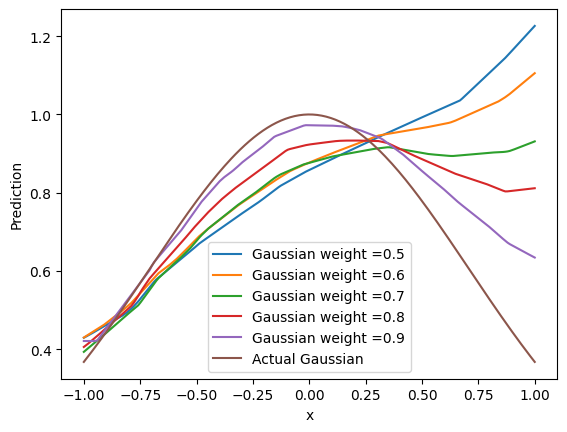

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def gaussian(x):
    return np.exp(-x**2)
    
x =  np.linspace(-1,1, 200)
y = gaussian(x)

plt.plot()

for weights in weights_list :

    model = output_models[weights["gaussian"]]
    x_tensor = torch.from_numpy(x).float().unsqueeze(-1)
    y_tensor = torch.from_numpy(y).float().unsqueeze(-1)
    
    predicted = model(x_tensor).detach().numpy()
    
    plt.plot(x, predicted, label="Gaussian weight =" +str(weights["gaussian"]))
    
plt.plot(x, y, label='Actual Gaussian')
plt.xlabel("x")
plt.ylabel("Prediction")
plt.legend()
    

##### As expected, as the weightage of the Gaussian model is increased, the outputs follow a Gaussian distribution